In [1]:
%pip freeze >> requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import yfinance as yf
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import scipy.stats as sps
import pmdarima as arima
from arch import arch_model

In [3]:
spy = yf.download("SPY", start="2010-01-01", end="2025-05-17")
time.sleep(1)
nvda = yf.download("NVDA", start="2010-01-01", end="2025-05-17")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
dates = spy.index.strftime('%Y-%m-%d')
dates

Index(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07', '2010-01-08',
       '2010-01-11', '2010-01-12', '2010-01-13', '2010-01-14', '2010-01-15',
       ...
       '2025-05-05', '2025-05-06', '2025-05-07', '2025-05-08', '2025-05-09',
       '2025-05-12', '2025-05-13', '2025-05-14', '2025-05-15', '2025-05-16'],
      dtype='object', name='Date', length=3867)

In [5]:
x = yf.download("X",start="2010-01-01", end="2025-05-17")
x.to_csv("x.csv")

[*********************100%***********************]  1 of 1 completed


In [6]:
nvda.to_csv('nvda.csv')
spy.to_csv('spy.csv')

In [7]:
print(nvda.shape)
print(nvda.columns)
print(spy.columns)

(3867, 5)
MultiIndex([( 'Close', 'NVDA'),
            (  'High', 'NVDA'),
            (   'Low', 'NVDA'),
            (  'Open', 'NVDA'),
            ('Volume', 'NVDA')],
           names=['Price', 'Ticker'])
MultiIndex([( 'Close', 'SPY'),
            (  'High', 'SPY'),
            (   'Low', 'SPY'),
            (  'Open', 'SPY'),
            ('Volume', 'SPY')],
           names=['Price', 'Ticker'])


In [8]:
print(spy.iloc[0].shape)
print(2*3774*2)

(5,)
15096


In [9]:
def load_data(file):
    xdat = pd.read_csv(file,skiprows=2)

    xdat.columns = ['Date','Close','High','Low','Open','Volume']
    xdat['Date'] = pd.to_datetime(xdat['Date'])
    
    return xdat

In [10]:
def plot_data(xdat:pd.DataFrame):
    plt.plot(xdat['Date'],xdat['Close'])
    plt.title("Prices")
    plt.show()

    xdat['logReturns'] = np.log1p(xdat.Close).diff()
    xdat['Squared_logReturns'] = (xdat.logReturns)**2

    plt.plot(xdat['Date'],xdat['logReturns'])
    plt.title("log-Returns")
    plt.show()

    plt.plot(xdat['Date'],xdat['Squared_logReturns'])
    plt.title("Squared log-Returns")
    plt.show()

# Asset 1

           Date      Close       High        Low       Open     Volume
3517 2023-12-22  48.811672  49.364462  48.448806  49.176533  252507000
3518 2023-12-26  49.260498  49.581377  48.941618  48.949614  244200000
3519 2023-12-27  49.398445  49.661347  49.066569  49.492412  233648000
3520 2023-12-28  49.503410  49.865274  49.393451  49.624367  246587000
3521 2023-12-29  49.503410  49.978234  48.732700  49.794301  389293000


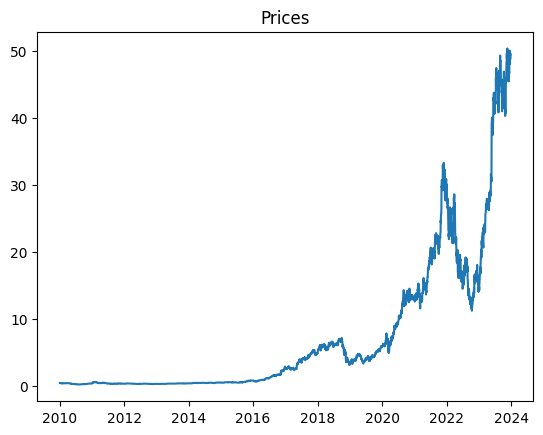

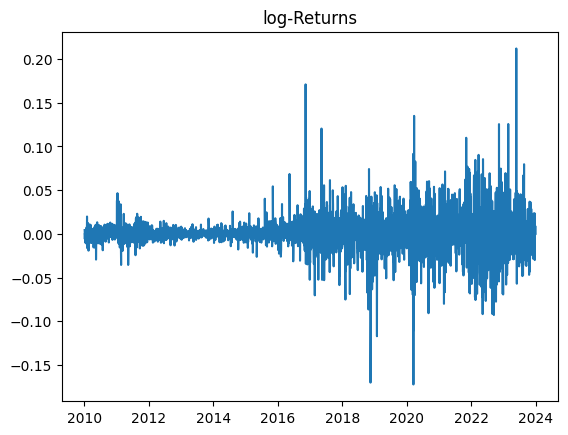

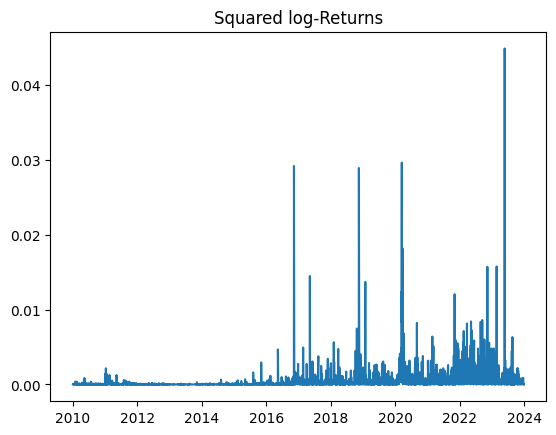

In [11]:
ticket = "nvda"
nvda = load_data(ticket + ".csv")
nvda = nvda[nvda['Date'] <= '2023-12-31']
print(nvda.tail())
plot_data(nvda)

# Asset 2

        Date      Close       High        Low       Open     Volume
0 2010-01-04  85.768448  85.813854  84.391067  85.041918  118944600
1 2010-01-05  85.995453  86.033295  85.405148  85.715440  111579900
2 2010-01-06  86.056023  86.267926  85.844119  85.912228  116074400
3 2010-01-07  86.419273  86.525225  85.654901  85.897078  131091100
4 2010-01-08  86.706886  86.744729  86.018199  86.192260  126402800


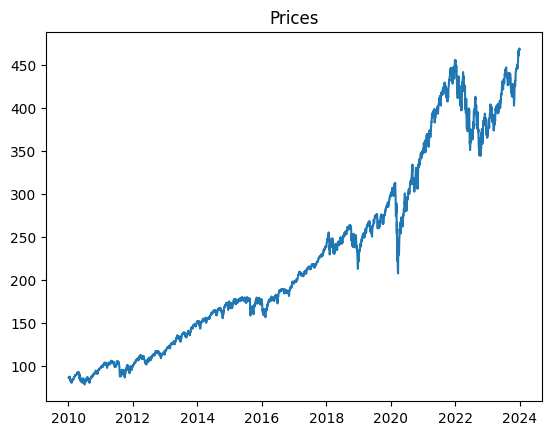

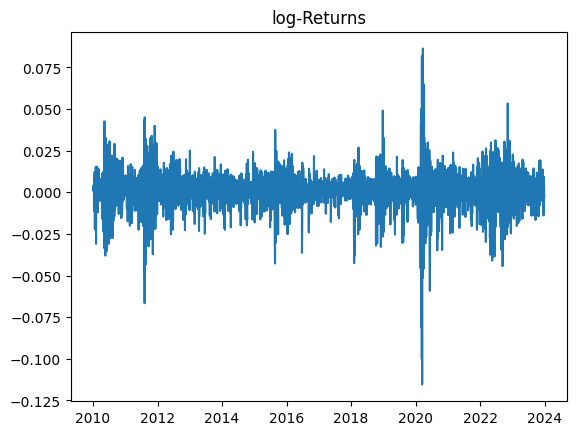

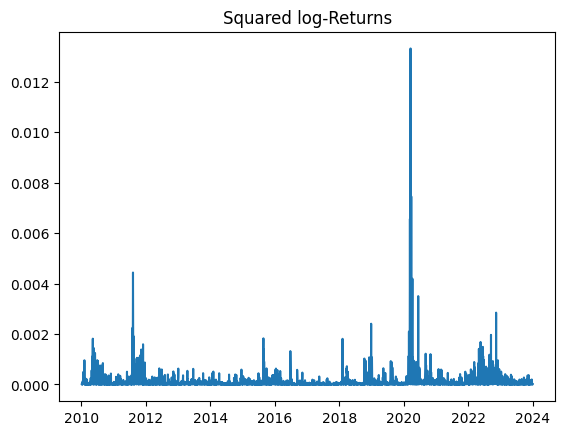

In [12]:
ticket = "spy"
spy = load_data(ticket+".csv")
spy = spy[spy['Date'] <= '2023-12-31']
print(spy.head())
plot_data(spy)

# Risk Comparison

In [13]:
def get_dataset(data, train: bool):
    if train:
        return data[data['Price'] <= '2023-12-31']
    else:
        return data[data['Price'] > '2023-12-31']

def compute_returns(data: pd.DataFrame):
    prices = data["Close"]
    returns = (prices / prices.shift(1)) - 1
    returns = returns.fillna(0)
    return returns

In [14]:
x = pd.read_csv("x.csv",skiprows=[1,2])
data = get_dataset(x,train=True)
x_r = compute_returns(data)

In [15]:
spy = pd.read_csv("spy.csv",skiprows=[1,2])
data = get_dataset(spy,train=True)
spy_r = compute_returns(data)

In [16]:
nvda = pd.read_csv("nvda.csv",skiprows=[1,2])
data = get_dataset(nvda,train=True)
nvda_r = compute_returns(data)

In [17]:
mean_spy=spy_r.expanding().mean()
mean_x=x_r.expanding().mean()
mean_nvda=nvda_r.expanding().mean()

var_spy=spy_r.expanding().var()
var_x=x_r.expanding().var()
var_nvda=nvda_r.expanding().var()

print("NaN in mean_spy:", mean_spy.isna().sum())
print("NaN in mean_x:", mean_x.isna().sum())
print("NaN in mean_nvda:", mean_nvda.isna().sum())

print("Length of mean_spy:", len(mean_spy))
print("Length of mean_x:", len(mean_x))
print("Length of mean_nvda:", len(mean_nvda))

NaN in mean_spy: 0
NaN in mean_x: 0
NaN in mean_nvda: 0
Length of mean_spy: 3522
Length of mean_x: 3522
Length of mean_nvda: 3522


In [18]:
b = mean_spy>mean_x
print(np.sum(b)/len(b))

b2 = var_spy>var_x
print(np.sum(b2)/len(b2))

0.9642248722316865
0.00028392958546280523


In [19]:
b = mean_spy>mean_nvda 
print(np.sum(b)/len(b))

b2 = var_spy>var_nvda
print(np.sum(b2)/len(b2))

0.3940942646223736
0.0


In [20]:
b = mean_nvda>mean_x 
print(np.sum(b)/len(b))

b2 = var_nvda>var_x 
print(np.sum(b2)/len(b2))

0.9327086882453152
0.049403747870528106


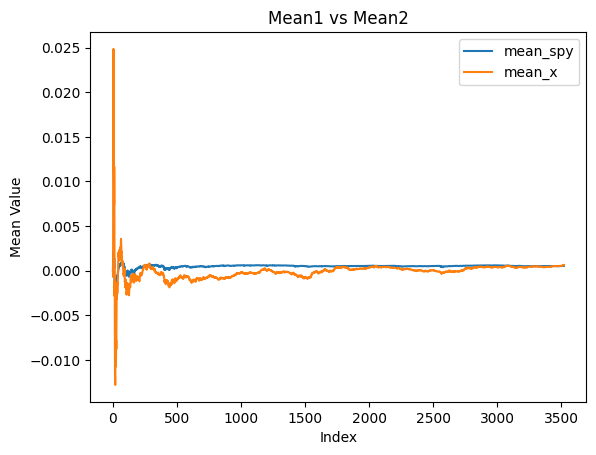

In [21]:
plt.plot(mean_spy, label='mean_spy')
plt.plot(mean_x, label='mean_x')
plt.title('Mean1 vs Mean2')
plt.xlabel('Index')
plt.ylabel('Mean Value')
plt.legend()
plt.show()

# Minimum Variance Portfolio

In [22]:
def get_mvp(var1,var2,cov):
    std1 = torch.sqrt(var1)
    std2 = torch.sqrt(var2)
    corr = cov/(std1*std2)
    nom = var2 - (corr*std1*std2)
    den = var1 + var2 - (2*corr*std1*std2)
    return nom/den

def get_capital_values(capital,w):
    return w * capital, (1-w)*capital

def get_return_values(returns,w):
    return w * returns + (1-w)*returns

$$\text{VaR}_\alpha = \mu + \sigma \Phi^{-1}(1-\alpha)$$

In [23]:
def get_VaR(alpha, mean, std):
    VaR = mean + (std*sps.norm.ppf(q=1-alpha,loc=0,scale=1))
    return VaR

def get_ES(alpha, mean, std):
    levels5 = np.linspace(0.001,1-alpha,40)
    q5 = sps.norm.ppf(levels5, 0, 1)
    mean5 = q5.mean()
    return mean + std*(mean5)

In [24]:
spy_test = get_dataset(spy,train=False)
spy_test_r = compute_returns(spy_test)

nvda_test = get_dataset(nvda,train=False)
nvda_test_r = compute_returns(nvda_test)

In [25]:
spy_r_log = (np.log1p(spy_r))
spy_r_squared = (np.log1p(spy_r))**2

nvda_r_log = (np.log1p(nvda_r))
nvda_r_squared = (np.log1p(nvda_r))**2

spy_test_r_log = (np.log1p(spy_test_r))
spy_test_r_squared = (np.log1p(spy_test_r))**2

nvda_test_r_log = (np.log1p(nvda_test_r))
nvda_test_r_squared = (np.log1p(nvda_test_r))**2

trading_days_2024 = dates[(dates >= '2024-01-01') & (dates <= '2024-12-31')]
start_2025_index = len(trading_days_2024)

train_length = len(spy_r_log)
test_length = len(spy_test_r_log)

assert len(spy_r_log) == len(spy_r_squared) == len(nvda_r_log) == len(nvda_r_squared), "Train sets do not have the same length"
assert len(spy_test_r_log) == len(spy_test_r_squared) == len(nvda_test_r_log) == len(nvda_test_r_squared), "Test sets do not have the same length"

# ARMA

The $ARMA(p, q)$ model combines autoregressive (AR) and moving average (MA) components in 
order to model a the returns of a financial asset. The AR part captures the relationship between an asset's current value and its past values, while the MA part captures the relationship between an asset's current value and past errors (shocks).
It is defined as follows:
$$
Y_t = \mu + \sum_{i=1}^{p} \phi_i Y_{t-i} + \sum_{j=1}^{q} \theta_j \epsilon_{t-j} + \epsilon_t \\
\text{where } \epsilon_t \sim N(0, \sigma^2)
$$
where:
- $Y_t$ is the value of the asset at time $t$,
- $\mu$ is the drift term,
- $\phi_i$ are the autoregressive coefficients,
- $\theta_j$ are the moving average coefficients,
- $\epsilon_t$ is a white noise error term at time $t$
- $p$ is the order of the autoregressive part,
- $q$ is the order of the moving average part.

In [26]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [27]:
def get_ARMA(returns):
    arma_model = arima.AutoARIMA(d=0,information_criterion="bic",suppress_warnings=True,trace=True)
    arma_model.fit(y=returns)
    return arma_model

def get_ARMA_predictions(arma_model,test_returns):
    arma_model.update(test_returns)
    prediction = arma_model.predict_in_sample()
    return prediction

def compute_VaR_ES(mean,variance,asset):

    train_VaR = get_VaR(alpha=0.95, mean=mean[:train_length], std=variance[:train_length]**0.5)
    test_VaR = get_VaR(alpha=0.95, mean=mean[-test_length:], std=variance[-test_length:]**0.5)
    print("Train SPY VaR:")
    print(np.asarray(train_VaR)[~np.isnan(train_VaR)].mean())
    print("Test SPY VaR:")
    print(np.asarray(test_VaR)[~np.isnan(test_VaR)].mean())

    train_ES = get_ES(alpha=0.95, mean=mean[:train_length], std=variance[:train_length]**0.5)
    test_ES = get_ES(alpha=0.95, mean=mean[-test_length:], std=variance[-test_length:]**0.5)
    print("Train "+asset+" ES:")
    print(np.asarray(train_ES)[~np.isnan(train_ES)].mean())
    print("Test "+asset+" ES:")
    print(np.asarray(test_ES)[~np.isnan(test_ES)].mean())

    assert len(train_VaR) == train_length, "Train VaR length mismatch"
    assert len(test_VaR) == test_length, "Test VaR length mismatch"
    assert len(train_ES) == train_length, "Train ES length mismatch"
    assert len(test_ES) == test_length, "Test ES length mismatch"

    return train_VaR, test_VaR, train_ES, test_ES

def compute_backtest_results(train_returns, test_returns, train_VaR, test_VaR):
    print(f"Train VaR coverage: {(np.where((train_returns <= train_VaR), 1, 0)).mean():.4f}")
    print(f"Test VaR coverage: {(np.where((test_returns <= test_VaR), 1, 0)).mean():.4f}")

    test_returns_2024 = test_returns.iloc[:start_2025_index]
    test_VaR_2024 = test_VaR[:start_2025_index]

    test_returns_2025 = test_returns.iloc[start_2025_index:]
    test_VaR_2025 = test_VaR[start_2025_index:]

    print(f"Test VaR coverage (2024): {(np.where((test_returns_2024 <= test_VaR_2024), 1, 0)).mean():.4f}")
    print(f"Test VaR coverage (2025): {(np.where((test_returns_2025 <= test_VaR_2025), 1, 0)).mean():.4f}")
    

def plot_train_VaR_ES(train_returns, train_VaR, train_ES):
    tail = test_length
    n = train_length
    date_range = dates.values[n-tail:n]

    plt.figure(figsize=(14, 6))
    plt.plot(date_range, train_returns.iloc[-tail:], label='Log Returns')
    plt.plot(date_range, train_VaR[-tail:], label='VaR95')
    plt.plot(date_range, train_ES[-tail:], label='ES95')
    plt.title(f"VaR and ES (Last {tail} Train Data)")
    plt.xlabel("Date")

    step = max(1, len(date_range) // 20)
    plt.xticks(ticks=np.arange(0, len(date_range), step), labels=date_range[::step], rotation=45)

    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_test_VaR_ES(test_returns, test_VaR, test_ES):
    tail = test_length
    date_range = dates[-tail:]
    
    plt.figure(figsize=(14, 6))
    plt.plot(date_range, test_returns.iloc[-tail:], label='Log Returns')
    plt.plot(date_range, test_VaR[-tail:], label='VaR95')
    plt.plot(date_range, test_ES[-tail:], label='ES95')
    plt.axvline(x=start_2025_index, color='red', linestyle='--', label='Start of 2025')
    plt.title(f"VaR and ES (Test Data)")
    plt.xlabel("Date")

    step = max(1, len(date_range) // 20)
    plt.xticks(ticks=np.arange(0, len(date_range), step), labels=date_range[::step], rotation=45)

    plt.legend()
    plt.tight_layout()
    plt.show()

In [28]:
spy_arma = get_ARMA(spy_r_squared)
print(spy_arma.summary())

Performing stepwise search to minimize bic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : BIC=-45875.481, Time=1.74 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : BIC=-44459.235, Time=0.24 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : BIC=-45186.201, Time=0.77 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : BIC=-44824.489, Time=0.82 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-44212.575, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : BIC=-45785.194, Time=1.23 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : BIC=-45879.155, Time=1.32 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : BIC=-45658.793, Time=0.99 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : BIC=-45877.457, Time=1.13 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : BIC=-45870.189, Time=0.82 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : BIC=-45878.561, Time=1.46 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : BIC=-45797.781, Time=1.82 sec
 ARIMA(2,0,1)(0,0,0)[0]             : BIC=-45854.940, Time=0.35 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0] intercept
Total fit time: 12.782 sec

In [29]:
spy_variance = get_ARMA_predictions(spy_arma,spy_test_r_squared)

In [30]:
zero_mean = np.zeros(train_length + test_length)
train_spy_VaR, test_spy_VaR, train_spy_ES, test_spy_ES = compute_VaR_ES(zero_mean, spy_variance, "SPY")

Train SPY VaR:
-0.015620345512715964
Test SPY VaR:
-0.015664498370956074
Train SPY ES:
-0.01942131693722987
Test SPY ES:
-0.019476213716105063


In [31]:
compute_backtest_results(spy_r_log, spy_test_r_log, train_spy_VaR, test_spy_VaR)

Train VaR coverage: 0.0591
Test VaR coverage: 0.0580
Test VaR coverage (2024): 0.0476
Test VaR coverage (2025): 0.0860


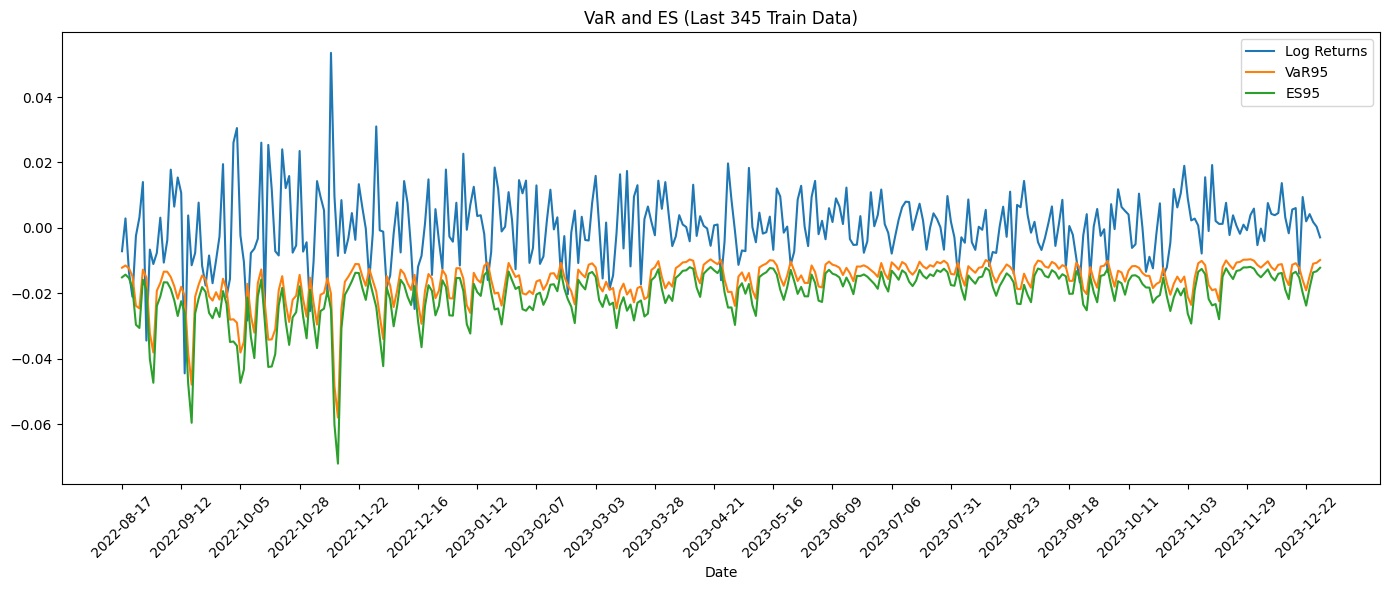

In [32]:
plot_train_VaR_ES(spy_r_log, train_spy_VaR, train_spy_ES)

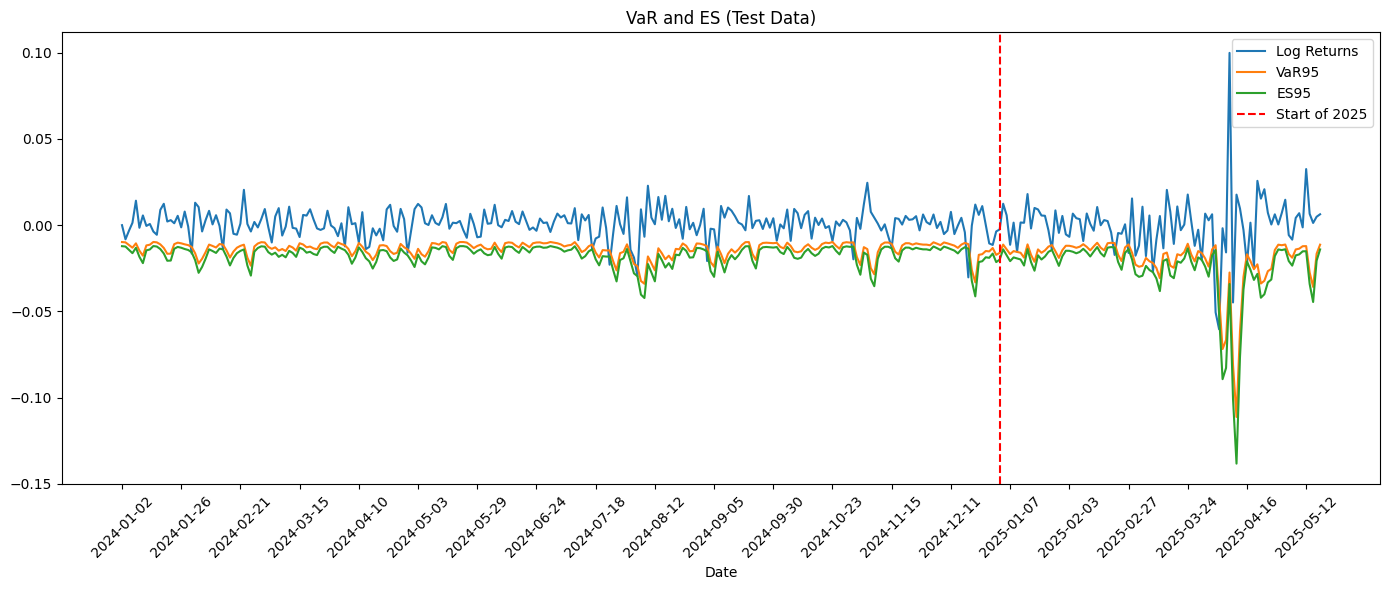

In [33]:
plot_test_VaR_ES(spy_test_r_log, test_spy_VaR, test_spy_ES)

In [34]:
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.arima.model import ARIMA

# Fit ARMA
arma_model = ARIMA(spy_r_squared, order=(2,0,1)).fit()
residuals = arma_model.resid

# ARCH test
arch_test = het_arch(residuals)
print("ARCH-LM p-value:", arch_test[1])


ARCH-LM p-value: 1.772208251553294e-214


c:\Users\panal\AppData\Local\Programs\Python\Python312\enviroments\ai-finance\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# GARCH

The $GARCH(p, q)$ model is used to model the volatility of a financial asset over time. It captures the time-varying nature of volatility by allowing past squared returns and past volatility to influence current volatility. 
It can be used in conjunction with $AR(r)$ model to capture both the mean and volatility dynamics of asset returns. This model is defined as follows:
$$
Y_t = \mu + \sum_{i=1}^{r} \phi_i Y_{t-i} + \epsilon_t \\
\text{where } \epsilon_t \sim \mathcal{N}(0, \sigma_t^2) \\
\sigma_t^2 = \omega + \sum_{i=1}^{p} \alpha_i \epsilon_{t-i}^2 + \sum_{j=1}^{q} \beta_j \sigma_{t-j}^2
$$
where:
- $\sigma_t^2$ is the conditional variance (volatility) at time $t$,
- $\omega$ is a constant term,
- $\alpha_i$ are the coefficients for past squared returns (ARCH terms),
- $\beta_j$ are the coefficients for past volatility (GARCH terms),
- $p$ is the order of the GARCH part,
- $q$ is the order of the ARCH part,
- $r$ is the order of the autoregressive part,
- $s$ is the order of the moving average part.

In [35]:
from sklearn.preprocessing import StandardScaler
scaler_spy_r_log = StandardScaler()
spy_r_log_s = scaler_spy_r_log.fit_transform(spy_r_log.values.reshape(-1, 1)).flatten()
spy_test_r_log_s = scaler_spy_r_log.transform(spy_test_r_log.values.reshape(-1, 1)).flatten()

spy_r_log_s = pd.Series(spy_r_log_s, index=spy_r_log.index)
spy_test_r_log_s = pd.Series(spy_test_r_log_s, index=spy_test_r_log.index)

In [ ]:
def get_GARCH(train_returns,test_returns,arma_p,arma_q,rescale):
    distributions = ['t','skewt']
    best_metric = np.inf
    best_model = None

    for dist in distributions:
        for p in range(1, 4):
            for q in range(1, 4):
                model = arch_model(train_returns, vol='GARCH', p=p, q=q, mean="AR", lags=arma_p, dist=dist, rescale=rescale)
                res = model.fit(disp='off',update_freq=0, cov_type="robust")

                if res.bic < best_metric:
                    best_metric = res.bic
                    best_model = res
                    best_config = (p, q, dist)
                print(f"Try: p={p}, q={q}, dist={dist}, BIC={res.bic:.2f}")

    print("Best config:", best_config)
    print("Best BIC:", best_metric)

    update_model = arch_model(np.concatenate([train_returns,test_returns]), vol='GARCH',
                            p=best_config[0], q=best_config[1], mean="AR", lags=arma_p, dist=best_config[2], rescale=rescale)
    update_res = update_model.fit(starting_values=best_model.params,disp='off',update_freq=0, cov_type="robust")
    return update_res

In [83]:
def get_GARCH(train_returns,test_returns,arma_p,arma_q,rescale):
    distributions = ['t','skewt','normal']
    best_metric = np.inf
    best_model = None

    for dist in distributions:
        for p in range(1, 4):
            for q in range(1, 4):
                model = arch_model(pd.concat([train_returns,test_returns]), vol='GARCH', p=p, q=q, mean="AR", lags=arma_p, dist=dist, rescale=rescale)
                res = model.fit(disp='off',update_freq=0, cov_type="robust",last_obs=train_length)

                if res.bic < best_metric:
                    best_metric = res.bic
                    best_model = res
                    best_config = (p, q, dist)
                print(f"Try: p={p}, q={q}, dist={dist}, BIC={res.bic:.2f}")

    print("Best config:", best_config)
    print("Best BIC:", best_metric)

    return best_model

In [60]:
def get_GARCH_prediction(garch_result):

    resid = garch_result.std_resid * garch_result.conditional_volatility
    mean = garch_result.model.y - resid

    variance = garch_result.conditional_volatility ** 2

    return mean, variance

In [118]:
def get_GARCH_prediction(garch_result):

    resid = garch_result.std_resid * garch_result.conditional_volatility
    train_mean = garch_result.model.y - resid

    train_variance = garch_result.conditional_volatility ** 2

    test_mean = garch_result.forecast(horizon=1,start=train_length).mean.values.flatten()
    test_variance = garch_result.forecast(horizon=1,start=train_length).variance.values.flatten()
    mean = np.concatenate([train_mean[:train_length], test_mean])
    variance = np.concatenate([train_variance[:train_length], test_variance])

    return mean, variance

In [97]:
garch_res = get_GARCH(spy_r_log_s,spy_test_r_log_s, arma_p=2, arma_q=1, rescale=False)

Try: p=1, q=1, dist=t, BIC=8261.41
Try: p=1, q=2, dist=t, BIC=8269.57
Try: p=1, q=3, dist=t, BIC=8277.74
Try: p=2, q=1, dist=t, BIC=8262.17
Try: p=2, q=2, dist=t, BIC=8269.63
Try: p=2, q=3, dist=t, BIC=8276.99
Try: p=3, q=1, dist=t, BIC=8270.34
Try: p=3, q=2, dist=t, BIC=8277.86
Try: p=3, q=3, dist=t, BIC=8284.93
Try: p=1, q=1, dist=skewt, BIC=8233.08
Try: p=1, q=2, dist=skewt, BIC=8241.24
Try: p=1, q=3, dist=skewt, BIC=8249.41
Try: p=2, q=1, dist=skewt, BIC=8232.28
Try: p=2, q=2, dist=skewt, BIC=8239.69
Try: p=2, q=3, dist=skewt, BIC=8247.11
Try: p=3, q=1, dist=skewt, BIC=8240.45
Try: p=3, q=2, dist=skewt, BIC=8247.67
Try: p=3, q=3, dist=skewt, BIC=8255.11
Try: p=1, q=1, dist=normal, BIC=8451.20
Try: p=1, q=2, dist=normal, BIC=8459.36
Try: p=1, q=3, dist=normal, BIC=8467.53
Try: p=2, q=1, dist=normal, BIC=8455.36
Try: p=2, q=2, dist=normal, BIC=8462.75
Try: p=2, q=3, dist=normal, BIC=8470.92
Try: p=3, q=1, dist=normal, BIC=8463.53
Try: p=3, q=2, dist=normal, BIC=8470.48
Try: p=3, q=3,

In [119]:
print("GARCH model summary:")
print(garch_res.summary())

GARCH model summary:
                                 AR - GARCH Model Results                                
Dep. Variable:                              None   R-squared:                       0.002
Mean Model:                                   AR   Adj. R-squared:                  0.001
Vol Model:                                 GARCH   Log-Likelihood:               -4079.39
Distribution:      Standardized Skew Student's t   AIC:                           8176.79
Method:                       Maximum Likelihood   BIC:                           8232.28
                                                   No. Observations:                 3520
Date:                           Fri, May 30 2025   Df Residuals:                     3517
Time:                                   18:25:35   Df Model:                            3
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
-----------

In [120]:
forecasted = garch_res.forecast(horizon=1, start=train_length)
print(len(forecasted.variance.values))

345


In [121]:
garch_mean,garch_variance = get_GARCH_prediction(garch_res)

print("NaN count in garch_mean:", np.isnan(garch_mean).sum())
print("NaN count in garch_variance:", np.isnan(garch_variance).sum())

print("Length of garch_mean:", len(garch_mean))
print("Length of garch_variance:", len(garch_variance))

NaN count in garch_mean: 2
NaN count in garch_variance: 2
Length of garch_mean: 3867
Length of garch_variance: 3867


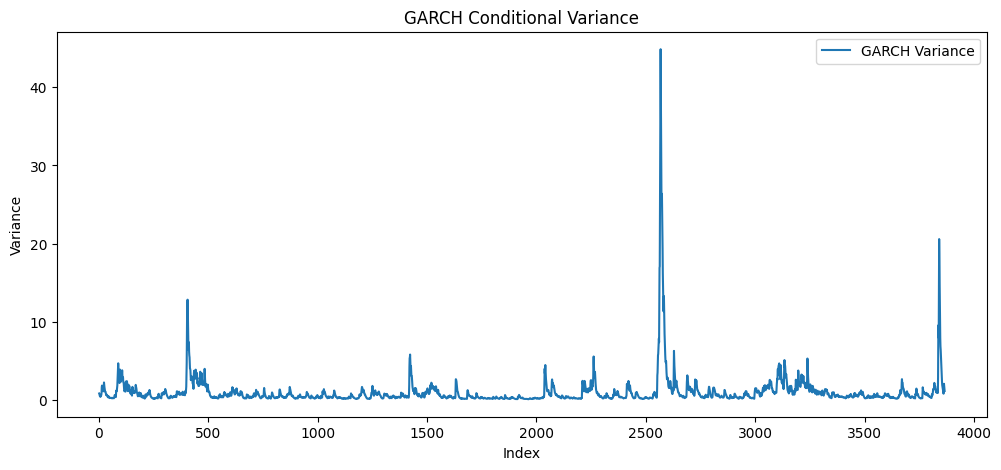

In [123]:
plt.figure(figsize=(12, 5))
plt.plot(garch_variance, label='GARCH Variance')
plt.title('GARCH Conditional Variance')
plt.xlabel('Index')
plt.ylabel('Variance')
plt.legend()
plt.show()

In [124]:
garch_train_spy_VaR, garch_test_spy_VaR, garch_train_spy_ES, garch_test_spy_ES = compute_VaR_ES(garch_mean, garch_variance, "SPY")

Train SPY VaR:
-1.4215424553477178
Test SPY VaR:
-1.4539609027475604
Train SPY ES:
-1.7747001017411081
Test SPY ES:
-1.8145042500481237


In [125]:
compute_backtest_results(spy_r_log_s, spy_test_r_log_s, garch_train_spy_VaR, garch_test_spy_VaR)

Train VaR coverage: 0.0616
Test VaR coverage: 0.0638
Test VaR coverage (2024): 0.0556
Test VaR coverage (2025): 0.0860


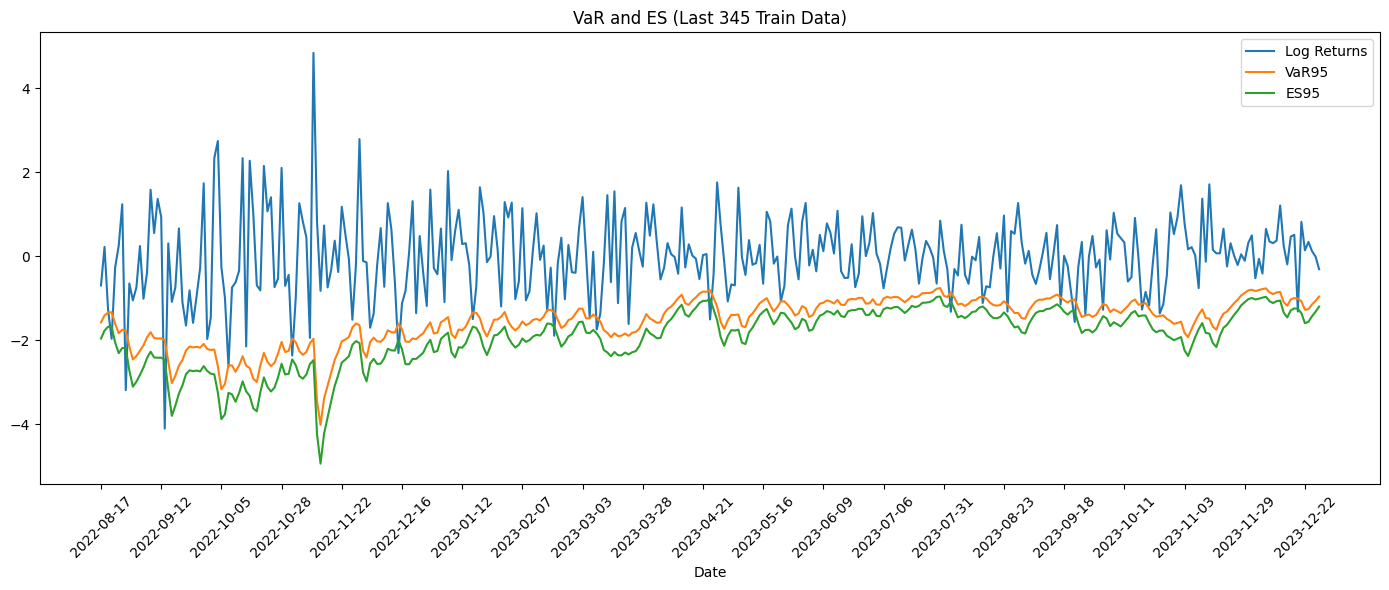

In [126]:
plot_train_VaR_ES(spy_r_log_s, garch_train_spy_VaR, garch_train_spy_ES)

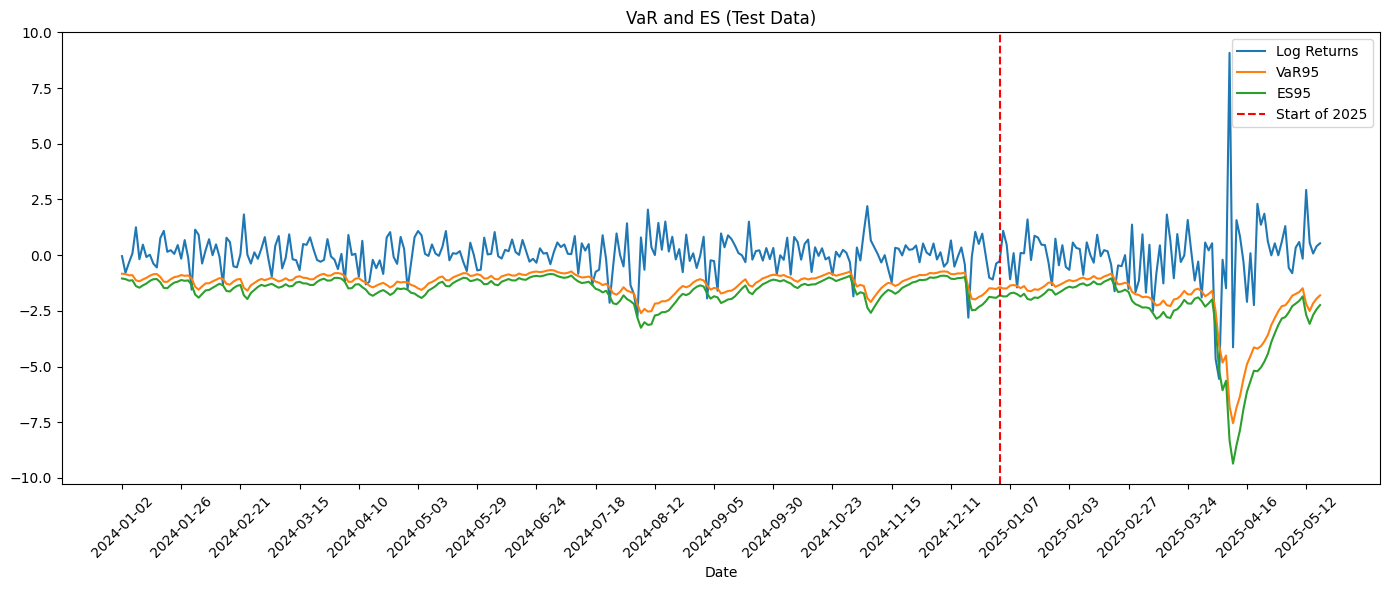

In [127]:
plot_test_VaR_ES(spy_test_r_log_s, garch_test_spy_VaR, garch_test_spy_ES)

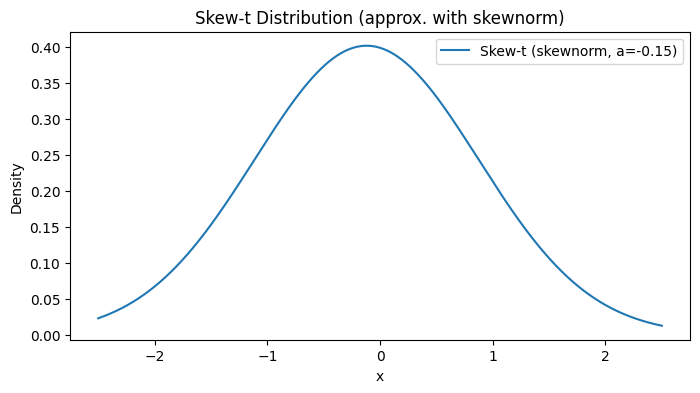

In [128]:
from scipy.stats import skewnorm

x_vals = np.linspace(-2.5, 2.5, 1000)

if hasattr(garch_res, 'params'):
    # Extract parameters for skewnorm: loc (mean), scale (std), a (skewness)
    loc = garch_res.params.get('mu', 0)
    scale = garch_res.params.get('sigma', 1)
    a = garch_res.params.get('lambda', 0)  # 'lambda' is the skew parameter in arch skewt

    # Draw the skew-t distribution using skewnorm (approximation)
    pdf_skew = skewnorm.pdf(x_vals, a, loc=loc, scale=scale)
    plt.figure(figsize=(8, 4))
    plt.plot(x_vals, pdf_skew, label=f'Skew-t (skewnorm, a={a:.2f})')
    plt.title('Skew-t Distribution (approx. with skewnorm)')
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.legend()
    plt.show()
else:
    print("GARCH model parameters not found.")